In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from collections import Counter
import numpy as np
from scipy import stats

In [2]:
data = pd.read_json('../../data/processed/data.json').T

## Preprocessing  

In [3]:
nutrition_df = data[['nutrition','rating','Tags']].reset_index()

In [4]:
tags_df1 = pd.DataFrame(data['Tags']).reset_index()

In [5]:
ingredients_df1 = pd.DataFrame(data['ingredient_annotations']).reset_index()

In [6]:
geographical_tags_updated = pd.DataFrame(data['geographical_tags_updated']).reset_index()

In [7]:
nutrition_df = nutrition_df.set_index(['index','rating'])

In [8]:
nutrition_df = nutrition_df['nutrition'].apply(pd.Series)

In [9]:
nutrition_df = nutrition_df.rename(columns = {0:'Calories',1:'Fat',2:'Carbs',3:'Fiber',4:'Sugar',5:'Protein'})

In [10]:
for i in nutrition_df.columns:
    nutrition_df[i] = nutrition_df[i].str.extract('(\d+)')[0]

In [11]:
calories = [4,4,9,4,2]
nutrition_df.iloc[:,1:] = nutrition_df.iloc[:,1:].apply(pd.to_numeric, errors='coerce')
nutrition_df.iloc[:,1:] = nutrition_df.iloc[:,1:]*calories #converting nutritional values grams to their equivalent in calories
nutrition_df = nutrition_df.reset_index()
#nutrition_df = nutrition_df.dropna()
#nutrition_df = nutrition_df[nutrition_df['rating'] != 'NA']


/var/folders/4l/wfp4gjq50mb26f_4tbq4618w0000gn/T/ipykernel_7382/3897436472.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  nutrition_df.iloc[:,1:] = nutrition_df.iloc[:,1:].apply(pd.to_numeric, errors='coerce')


In [12]:
nutrition_tags = pd.merge(nutrition_df,tags_df1, on = 'index',how = 'inner')

In [13]:
nutrition_tags = pd.merge(nutrition_tags,ingredients_df1, on = 'index',how = 'inner')

In [14]:
nutrition_tags = pd.merge(nutrition_tags,geographical_tags_updated,on = 'index',how = 'inner')

In [15]:
nutrition_tags['Proteins/Calories'] = nutrition_tags['Protein']/nutrition_tags['Calories'].astype(float)
nutrition_tags['Fat/Calories'] = nutrition_tags['Fat']/nutrition_tags['Calories'].astype(float)
nutrition_tags['Carbs/Calories'] = nutrition_tags['Carbs']/nutrition_tags['Calories'].astype(float)
nutrition_tags['Fiber/Calories'] = nutrition_tags['Fiber']/nutrition_tags['Calories'].astype(float)
nutrition_tags['Sugar/Calories'] = nutrition_tags['Sugar']/nutrition_tags['Calories'].astype(float)

In [16]:
nutrition_tags['Tags Count'] = nutrition_tags['Tags'].apply(len)

In [17]:
nutrition_tags['Ingredients Count'] = nutrition_tags['ingredient_annotations'].apply(len)

In [18]:
nutrition_tags['Geographical Tags Count'] = nutrition_tags['geographical_tags_updated'].apply(len) 

In [19]:
#nutrition_tags = nutrition_tags[nutrition_tags['Tags Count'] <= 50]

In [20]:
dict1 = {}
for i,j in zip(nutrition_tags['Proteins/Calories'],nutrition_tags['Tags']):
    for x in j:
        dict1.setdefault(x,[]).append(i)

In [21]:
dict_mean = {}
for i,j in dict1.items():
    dict_mean[i] = (np.mean(j),len(j))

In [22]:
mean_percentage_protein = pd.DataFrame.from_dict(dict_mean,orient='index') #wrong

In [23]:
no_comments = pd.DataFrame(data['number_of_comments'].str.strip('TIPS').astype(int)).reset_index()

In [24]:
no_comments['comments_rank'] = no_comments['number_of_comments'].rank(ascending=False,method = 'first')

In [25]:
df = pd.merge(nutrition_tags,no_comments, on = 'index',how = 'inner')

In [26]:
df.loc[df['rating'] == 'NA','rating'] = np.nan

In [27]:
df['rating'] = df['rating'].apply(float)

## EDA 

In [28]:
len(df)

2967

#### Comments

In [29]:
print(df['number_of_comments'].describe().to_latex())

\begin{tabular}{lr}
\toprule
{} &  number\_of\_comments \\
\midrule
count &         2967.000000 \\
mean  &           78.236266 \\
std   &          195.582495 \\
min   &            0.000000 \\
25\%   &            5.000000 \\
50\%   &           24.000000 \\
75\%   &           80.000000 \\
max   &         4704.000000 \\
\bottomrule
\end{tabular}



In [62]:
df['number_of_comments'].mean()

78.23626558813616

In [30]:
len(df[df['number_of_comments'] == 0])

266

In [31]:
df['number_of_comments'].sum() # total number of comments

232127

#### Ingredients

In [32]:
distinct_ingred = set()
for i in df['ingredient_annotations']:
    for j in i:
        distinct_ingred.add(j)

In [33]:
len(distinct_ingred) # total number of distinct ingredients

1856

In [34]:
df['Ingredients Count'].describe() # average number of ingredients per recipe

count    2967.000000
mean       13.788675
std         6.142731
min         2.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        59.000000
Name: Ingredients Count, dtype: float64

#### Tags

In [35]:
distinct_tags = set()
for i in df['Tags']:
    for j in i:
        distinct_tags.add(j)

In [36]:
len(distinct_tags)

202

In [37]:
df['Tags Count'].describe() # average number of tags per recipe

count    2967.000000
mean       20.700371
std         8.130606
min         4.000000
25%        16.000000
50%        19.000000
75%        23.000000
max        90.000000
Name: Tags Count, dtype: float64

In [38]:
distinct_geo_tags = set()
for i in df['geographical_tags_updated']:
    for j in i:
        distinct_geo_tags.add(j)

In [39]:
len(distinct_geo_tags)

41

In [40]:
df['Geographical Tags Count'].describe()

count    2967.000000
mean        1.735086
std         1.440407
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        16.000000
Name: Geographical Tags Count, dtype: float64

#### Nutritional info

In [41]:
df['Calories'].astype(float).describe() # average calories per recipe

count    2486.000000
mean      581.688254
std       327.356648
min         4.000000
25%       337.000000
50%       527.000000
75%       763.750000
max      2144.000000
Name: Calories, dtype: float64

In [42]:
df['Carbs/Calories'].describe() # average percentage of carbs in calories per recipe

count    2486.000000
mean        0.341528
std         0.185111
min         0.000000
25%         0.206704
50%         0.328225
75%         0.457682
max         1.085714
Name: Carbs/Calories, dtype: float64

In [43]:
df['Fat/Calories'].describe() # average percentage of fat in calories per recipe

count    2486.000000
mean        0.193284
std         0.075945
min         0.000000
25%         0.143989
50%         0.194245
75%         0.246863
max         0.450617
Name: Fat/Calories, dtype: float64

In [44]:
df['Fiber/Calories'].describe() # average percentage of fiber in calories per recipe

count    2486.000000
mean        0.141673
std         0.220988
min         0.000000
25%         0.033978
50%         0.072058
75%         0.161255
max         3.133333
Name: Fiber/Calories, dtype: float64

In [45]:
df['Proteins/Calories'].describe() # average percentage of protein in calories per recipe

count    2486.000000
mean        0.106515
std         0.056832
min         0.000000
25%         0.065934
50%         0.097821
75%         0.139382
max         0.428571
Name: Proteins/Calories, dtype: float64

In [46]:
df['Sugar/Calories'].describe() # average percentage of sugar in calories per recipe

count    2486.000000
mean        0.077575
std         0.084753
min         0.000000
25%         0.026022
50%         0.052632
75%         0.096247
max         0.705036
Name: Sugar/Calories, dtype: float64

In [60]:
len(df[df['Calories'].isna()])

481

#### RATING

In [57]:
print(df['rating'].describe().to_latex())

\begin{tabular}{lr}
\toprule
{} &       rating \\
\midrule
count &  2287.000000 \\
mean  &    91.494534 \\
std   &     7.628562 \\
min   &    20.000000 \\
25\%   &    90.000000 \\
50\%   &    94.000000 \\
75\%   &    96.000000 \\
max   &   100.000000 \\
\bottomrule
\end{tabular}



In [61]:
df['rating'].mean()

91.4945343244425

In [59]:
len(df[df['rating'].isna() == True])

680

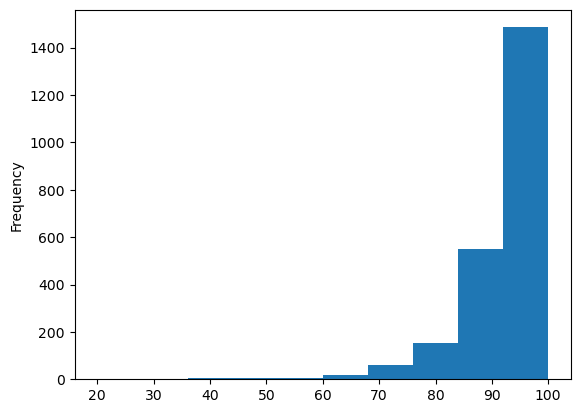

In [49]:
df['rating'].plot.hist();

## Separate DFs

In [51]:
ingredients = [j for i in df['ingredient_annotations'] for j in i]

In [52]:
ingredients_df = pd.DataFrame.from_dict(dict(Counter(ingredients)),orient = 'index').rename(columns = {0:'Count'}).sort_values(by='Count',ascending = False)

In [53]:
tags = [j for i in df['Tags'] for j in i]

In [54]:
tags_df = pd.DataFrame.from_dict(dict(Counter(tags)),orient = 'index').rename(columns = {0:'Count'}).sort_values(by='Count',ascending = False)

In [55]:
geo_tags = [j for i in df['geographical_tags_updated'] for j in i]

In [56]:
geo_tags_df = pd.DataFrame.from_dict(dict(Counter(geo_tags)),orient = 'index').rename(columns = {0:'Count'}).sort_values(by='Count',ascending = False)